<a href="https://colab.research.google.com/github/Bennath-coder/Bennath-coder/blob/main/S5_007P_a%CC%80_009P_UseCaseEnonce_DL_NLP_vNPz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
data = pd.read_csv("S5_007_009_ratings.csv")
data.head()

,UserId,ProductId,Rating,Description
0,AKJHHD5VEH7VG,0762451459,5.0,JSR Paris Beauty Cotton Net Women's Full Cover...
1,A22ZFXQE8AWPEP,1304482596,1.0,"BlueStone The Golden Arm Yellow Gold Diamond, ..."
2,A22ZFXQE8AWPEP,1304482685,1.0,Okane Striped Men's Polo Neck T-Shirt - Buy Go...
3,A22ZFXQE8AWPEP,1304495396,1.0,Her Grace Women's A-line Dress - Buy Blue Her ...
4,A22ZFXQE8AWPEP,1304511111,1.0,Buy Eventz Gifts Allah Showpiece - 20 cm for...


In [3]:
data.shape

(181040, 4)

In [4]:
ratings = data[["UserId", "ProductId", "Rating"]].sample(10000, random_state=42)

In [5]:
ratings.shape

(10000, 3)

Dans ce dataset, on dispose des notes (entre 1 et 5) émises par des clients d'une marketplace sur des produits spécifiques. Les clients et les produits sont identifiables via leurs identifiants.

**Quels sont les produits les plus populaires (c'est-à-dire ceux qui ont obtenu le plus de notes) ?**

In [6]:
data.groupby("ProductId")["Rating"].count().sort_values(ascending=False)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
...,...
B001SG7EE0,1
B001SKWB1C,1
B001SP7RV6,1


**Quels sont les utilisateurs les plus actifs (c'est-à-dire ceux qui ont noté le plus de produits) ?**

In [7]:
data.groupby("UserId")["Rating"].count().sort_values(ascending=False)

,Rating
UserId,
A3KEZLJ59C1JVH,389
A281NPSIMI1C2R,336
A3M174IC0VXOS2,326
A2V5R832QCSOMX,278
A3LJLRIZL38GG3,276
...,...
A2BIYSOWGIVNHB,1
A2BIQ0KPVMG8B2,1
A2BIOHEVF0LCHW,1


# Recommandation à partir des descriptions des produits

Supposons désormais que nous n'avons pas accès à l'historique d'achat des clients. Nous allons baser notre recommandation sur les descriptions des produits. Commençons par créer un dataset comportant une liste de 1000 produits et leurs descriptions :

In [8]:
product_descriptions = data[["ProductId", "Description"]].drop_duplicates().sample(1000, random_state=42)

Avant de vectoriser nos descriptions, nous allons ajouter à la liste des stop_words anglais quelques termes spécifiques au e-commerce qu'on retrouve dans un grand nombre de descriptions de produits :

In [9]:
stop_words = ENGLISH_STOP_WORDS.union(['shipping', 'online', 'guarantee', 'replacement', 'delivery', 'cash', 'free',
                                      'buy', 'day', 'discounts', 'products', 'flipkart', 'prices', 'warranty',
                                      'specifications', 'details', 'features', 'general', 'pack', 'price',
                                      'package', 'sales', 'box', 'type', 'genuine', 'material', 'cm'])
stop_words = list(stop_words)

**Créer un `TfidfVectorizer` en spécifiant les stop_words ci-dessus et récupérer les vecteurs associés aux descriptions.**

In [13]:
# Extract the 'Description' column as a series of strings
descriptions = product_descriptions["Description"].astype(str)

#on ajoute dans le vectorizer quelques mots spécifiques de la descrption des produits en e-commerce qui ne seront pas utiles à notre analyse
tfidf = TfidfVectorizer(stop_words=['shipping', 'online', 'guarantee', 'replacement', 'delivery', 'cash', 'free',
                                      'buy', 'day', 'discounts', 'products', 'flipkart', 'prices', 'warranty',
                                      'specifications', 'details', 'features', 'general', 'pack', 'price',
                                      'package', 'sales', 'box', 'type', 'genuine', 'material', 'cm']) # je défini mon TF-IDF et je vais spécifier un certain nombre de 'stop_words' propresaux recommandations à partir des descriptions des produits pour ne pas altérer l'analyse
wc_tfidf = tfidf.fit_transform(descriptions.tolist()) # j'entraîne mon modèle càd calculer les valeurs pour mon label descriptions

In [16]:
wc_tfidf

<1000x5553 sparse matrix of type '<class 'numpy.float64'>'
	with 31747 stored elements in Compressed Sparse Row format>

In [15]:
len(tfidf.vocabulary_)

5553

In [14]:
tfidf.vocabulary_

{'april6': 887,
 'carmelo': 1306,
 'printed': 3958,
 'men': 3324,
 'boxer': 1175,
 'orange': 3646,
 'for': 2371,
 'only': 3629,
 'rs': 4273,
 '549': 480,
 'in': 2792,
 'india': 2804,
 'shop': 4473,
 'apparels': 872,
 'huge': 2731,
 'collection': 1483,
 'of': 3603,
 'branded': 1187,
 'clothes': 1451,
 'at': 930,
 'com': 1497,
 'maxima': 3299,
 '13881ppgw': 104,
 'fiber': 2275,
 'analog': 837,
 'watch': 5354,
 '699': 552,
 'tonneau': 5039,
 'dial': 1854,
 'water': 5356,
 'resistant': 4197,
 'stainless': 4684,
 'steel': 4708,
 'back': 985,
 'case': 1316,
 'buckle': 1230,
 'clasp': 1427,
 'black': 1114,
 'strap': 4747,
 'great': 2550,
 '30': 322,
 'on': 3623,
 'key': 2990,
 'timberlake': 5008,
 'slim': 4562,
 'fit': 2309,
 'women': 5446,
 'red': 4129,
 'jeans': 2907,
 'color': 1486,
 'standard': 4688,
 'brand': 1186,
 'number': 3581,
 'contents': 1577,
 'fabric': 2202,
 '70': 556,
 'cotton30': 1616,
 'lycra': 3219,
 'pattern': 3752,
 'solid': 4604,
 'ideal': 2752,
 'additional': 729,
 'sty

**Regrouper les vecteurs en 8 clusters avec la méthode des $k$-means.**

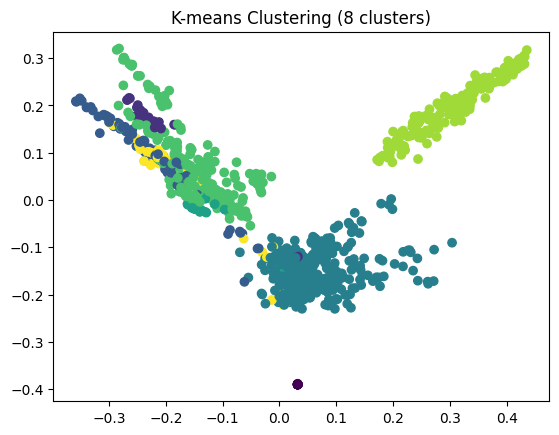

Centres des clusters : [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00793985 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00108988 0.00135504]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00190463 0.         0.         ... 0.         0.         0.        ]]


In [34]:
# Créer des données d'exemple (vecteurs)

# 1. Vectoriser les documents avec TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(descriptions)

# 2. Appliquer l'algorithme K-means avec 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

# 3. Récupérer les labels des clusters (les indices des clusters)
labels = kmeans.labels_

# 4. Perform dimensionality reduction for visualization (e.g., using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Reduce to 2 dimensions for plotting
X_reduced = pca.fit_transform(X.toarray()) # Convert sparse matrix to dense for PCA

# 5. Visualisation des clusters (si données en 2D)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.title("K-means Clustering (8 clusters)")
plt.show()

# 6. Récupérer les centres des clusters
centroids = kmeans.cluster_centers_
print("Centres des clusters :", centroids)

Nous pouvons maintenant identifier les termes les plus présents dans chaque cluster :

In [35]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(8):
    print(f"Cluster {i}:"),
    for ind in order_centroids[i, :10]:
        print(terms[ind]),

Top terms per cluster:
Cluster 0:
covers
sturdiness
ways
puppy
lost
robust
matte
impress
elegance
class
Cluster 1:
art
pencil
com
flipkart
dailyobjects
plastic
box
guarantee
30
replacement
Cluster 2:
necklace
alloy
guarantee
30
replacement
metal
shipping
day
cash
delivery
Cluster 3:
details
fabric
women
features
type
color
cotton
specifications
general
pack
Cluster 4:
mat
allure
car
auto
cm
prices
best
hyundai
1599
online
Cluster 5:
shipping
cash
delivery
genuine
products
free
guarantee
30
replacement
day
Cluster 6:
online
shirt
women
branded
shop
huge
apparels
clothes
india
collection
Cluster 7:
bangle
set
alloy
jewel
gold
guarantee
30
replacement
cash
shipping


**Quels types de produits allons-nous retrouver dans chaque cluster ?**

Imaginons le terme de recherche : *car accessory* (accessoire voiture). Tentons de trouver des produits pertinents autour de cette recherche.

**Vectoriser le terme de recherche puis trouver le cluster associé.**

In [65]:
# Exemple de descriptions de produits d'accessoires pour voiture
data_car_accessory = list(data['Description'].unique())

# Remove or replace np.nan values
data_car_accessory = [str(desc) for desc in data_car_accessory if pd.notna(desc)] # Converts np.nan to 'nan' string and keeps other strings

# 1. Vectorisation des descriptions des produits avec TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_car_accessory)

# 2. Appliquer KMeans avec 8 clusters (on suppose ici qu'on veut regrouper en deux grandes catégories d'accessoires)
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

# 3. Vectoriser le terme de recherche "car accessory"
term = ["car accessory"]
term_vector = vectorizer.transform(term)

# 4. Prédire à quel cluster appartient ce terme
predicted_cluster = kmeans.predict(term_vector)

# Afficher le cluster associé
print(f"Le terme 'car accessory' appartient au cluster : {predicted_cluster[0]}")

Le terme 'car accessory' appartient au cluster : 3


**Proposer un produit issu de ce cluster.**

In [77]:
# Exemple de descriptions de produits d'accessoires pour voiture (données d'entraînement)
cluster3_descriptions = list(data['Description'].unique())

# Remove or replace np.nan values
cluster3_descriptions = [str(desc) for desc in cluster3_descriptions if pd.notna(desc)] # Converts np.nan to 'nan' string and keeps other strings

# 1. Vectorisation des descriptions des produits avec TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(cluster3_descriptions)

# 2. Appliquer KMeans avec 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

# 3. Trouver les produits appartenant au cluster 3
cluster3_car_accessory = [cluster3_descriptions[i] for i, label in enumerate(kmeans.labels_) if label == 3]

# Affichage d'un produit de ce cluster
print(f"A product related to the car accessory in cluster nb. 3 could be : {cluster3_car_accessory[0]}")


A product related to the car accessory in cluster nb. 3 could be : Aussehen Women's Solid Casual Shirt
                         Price: Rs. 499
				
			Embrace the button-front trend with this beautifully styled sleeveless top from Aussehen.
Embrace the button-front trend with this beautifully styled sleeveless top from Aussehen.
